# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import NCFDataset
from helpers.dataloader_custom_functions import collate_fn
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner
from helpers.splitter import Splitter

# Loading data

In [2]:
df = pd.read_csv('../data/interaction-clean.csv')[['user_id', 'item_id', 'rating_imp', 'timestamp']]
df.head()

,user_id,item_id,rating_imp,timestamp
0,76561197960432447,10,1,1738278781
1,76561198071230926,10,1,1736206418
2,76561198206216352,10,1,1738041574
3,76561198110801124,10,1,1738015332
4,76561199813732773,10,1,1737853720


# Indexing data

In [3]:
index_manager = IndexManager()
index_manager.fit(df_interaction=df)
index_manager.transform_interactions(df, inplace=True)
df.head()

Indexed 836887 users and 69001 items
User index range: 0-836886
Item index range: 0-69000


,user_id,item_id,rating_imp,timestamp
0,0,0,1,1738278781
1,1,0,1,1736206418
2,2,0,1,1738041574
3,3,0,1,1738015332
4,4,0,1,1737853720


# Splitting data

In [4]:
splitter = Splitter(df)
df_train, df_val, df_test = splitter.leave_k_out_split()

Splitting data with leave-2-out strategy (1 for validation, 1 for testing)
Total users: 836887
Interactions per user: min=1, max=1035, avg=1.4
Note: 706515 users have fewer than 2 interactions.
These users will be placed entirely in the training set.
Split complete: 1156226 total interactions
Train set: 895482 interactions (77.4%)
Validation set: 130372 interactions (11.3%)
Test set: 130372 interactions (11.3%)


# Tuning model

In [5]:
unique_users = index_manager.get_indexed_users()
unique_items = index_manager.get_indexed_items()

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
)

In [6]:
param_grid = {
            'factors': [8, 16, 32, 64],
            'mlp_user_item_dim': [32, 64, 128],
            'learning_rate': [0.0005, 0.001],
            'epochs': [200],
            'optimizer': ['adagrad'],
            'dropout': [0.0, 0.2, 0.5],
            'weight_decay': [0.0, 0.0001, 0.0005, 0.001],
            'loss_fn': ['bce', 'mse', 'bpr'],
            'batch_size': [8192, 16384],
}

tuner.set_param_grid(param_grid)

In [7]:
results, file_path = tuner.perform_random_search(num_trials=30)

Running experiment with params: {'factors': 64, 'mlp_user_item_dim': 32, 'learning_rate': 0.001, 'epochs': 200, 'optimizer': 'adagrad', 'dropout': 0.0, 'weight_decay': 0.0005, 'loss_fn': 'bpr', 'batch_size': 8192}
Epoch 1/200
Train loss: 0.671219, Validation loss: 0.668838
Epoch 2/200
Train loss: 0.664795, Validation loss: 0.663944
Epoch 3/200
Train loss: 0.659266, Validation loss: 0.658174
Epoch 4/200
Train loss: 0.648736, Validation loss: 0.644797
Epoch 5/200
Train loss: 0.628665, Validation loss: 0.626360
Epoch 6/200
Train loss: 0.603910, Validation loss: 0.604672
Epoch 7/200
Train loss: 0.574996, Validation loss: 0.580790
Epoch 8/200
Train loss: 0.544502, Validation loss: 0.557040
Epoch 9/200
Train loss: 0.514583, Validation loss: 0.534883
Epoch 10/200
Train loss: 0.486707, Validation loss: 0.515085
Epoch 11/200
Train loss: 0.461279, Validation loss: 0.498119
Epoch 12/200
Train loss: 0.439030, Validation loss: 0.484378
Epoch 13/200
Train loss: 0.420387, Validation loss: 0.473749
Ep

In [8]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0005, 'epochs': 200, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0001, 'loss_fn': 'mse', 'batch_size': 8192}, 'value': 0.03213880281041941}, 'NDCG@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0005, 'epochs': 200, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0001, 'loss_fn': 'mse', 'batch_size': 8192}, 'value': 0.015641408814800854}, 'Recall@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0005, 'epochs': 200, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0001, 'loss_fn': 'mse', 'batch_size': 8192}, 'value': 0.03213880281041941}}


# Analyzing results

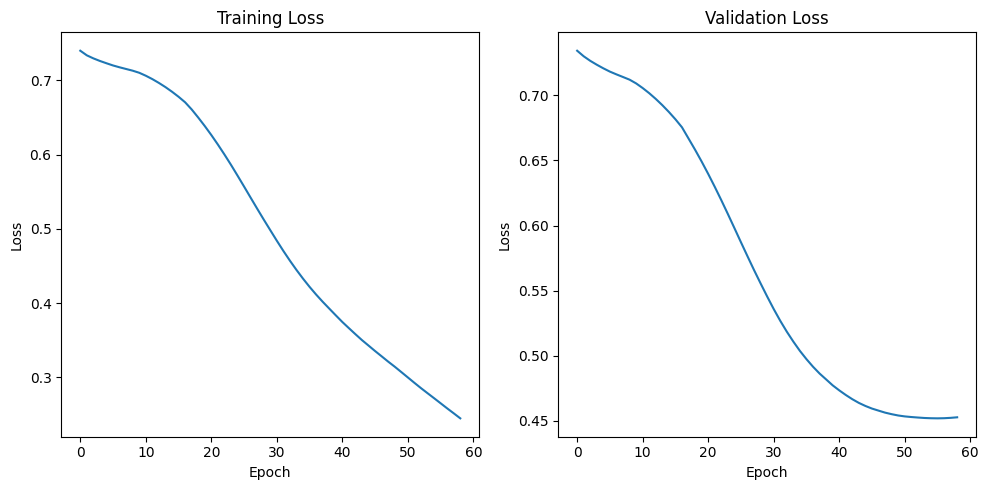

In [9]:
df_result = tuner.plot_results()

In [24]:
df_result

,factors,mlp_user_item_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,Hit Ratio@10,NDCG@10,Recall@10
0,64,32,0.0010,200,adagrad,0.0,0.0005,bpr,8192,0.023464,0.011183,0.023464
1,64,128,0.0010,200,adagrad,0.5,0.0010,bce,16384,0.019843,0.009214,0.019843
2,8,32,0.0010,200,adagrad,0.2,0.0005,mse,16384,0.012802,0.006446,0.012802
3,16,64,0.0005,200,adagrad,0.0,0.0010,mse,8192,0.028327,0.014027,0.028327
4,8,128,0.0005,200,adagrad,0.2,0.0005,bce,16384,0.023180,0.011085,0.023180
5,16,128,0.0010,200,adagrad,0.2,0.0001,bce,8192,0.018156,0.008961,0.018156
6,32,32,0.0005,200,adagrad,0.2,0.0000,bpr,8192,0.029884,0.014673,0.029884
7,32,64,0.0005,200,adagrad,0.2,0.0005,bce,16384,0.024837,0.012870,0.024837
8,16,128,0.0010,200,adagrad,0.5,0.0000,mse,8192,0.014857,0.008559,0.014857
9,32,64,0.0005,200,adagrad,0.2,0.0001,mse,8192,0.032139,0.015641,0.032139


# Train model with best params

In [11]:
best_param = best_params['Hit Ratio@10']['params']

train_dataset = NCFDataset(df_train)
val_dataset = NCFDataset(df_val)

dataloader_params = {
    'batch_size': best_param.pop('batch_size', 8192),
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 2,
    'pin_memory': True,
    'shuffle': True,
    'collate_fn': collate_fn
}

train_dataloader = DataLoader(train_dataset, **dataloader_params)
eval_dataloader = DataLoader(val_dataset, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, **best_param)
model.fit(train_dataloader, eval_dataloader)

evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Epoch 1/200
Train loss: 0.227797, Validation loss: 0.226853
Epoch 2/200
Train loss: 0.224276, Validation loss: 0.224191
Epoch 3/200
Train loss: 0.221682, Validation loss: 0.221891
Epoch 4/200
Train loss: 0.219311, Validation loss: 0.219677
Epoch 5/200
Train loss: 0.216976, Validation loss: 0.217491
Epoch 6/200
Train loss: 0.214664, Validation loss: 0.215299
Epoch 7/200
Train loss: 0.212288, Validation loss: 0.213051
Epoch 8/200
Train loss: 0.209837, Validation loss: 0.210733
Epoch 9/200
Train loss: 0.207198, Validation loss: 0.208222
Epoch 10/200
Train loss: 0.204472, Validation loss: 0.205613
Epoch 11/200
Train loss: 0.201478, Validation loss: 0.202834
Epoch 12/200
Train loss: 0.198090, Validation loss: 0.199665
Epoch 13/200
Train loss: 0.194453, Validation loss: 0.196283
Epoch 14/200
Train loss: 0.190602, Validation loss: 0.192725
Epoch 15/200
Train loss: 0.186627, Validation loss: 0.189121
Epoch 16/200
Train loss: 0.182734, Validation loss: 0.185570
Epoch 17/200
Train loss: 0.178874

In [12]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0371322
NDCG@10:	 0.0187321
Recall@10:	 0.0371322


# Interpretting predictions

In [13]:
df_interaction_count = df.groupby('user_id')[['item_id']].nunique().sort_values('item_id', ascending=False)

In [14]:
df_interaction_count[df_interaction_count['item_id'] == 10]

,item_id
user_id,
141666,10
158712,10
50193,10
255627,10
52048,10
...,...
118056,10
356725,10
17134,10


In [15]:
user_id = 141666

In [16]:
df[df['user_id'] == user_id]

,user_id,item_id,rating_imp,timestamp
158130,141666,33017,0,1641471440
168364,141666,33789,0,1612374138
324424,141666,45795,1,1704051359
384844,141666,50159,0,1703965957
699841,141666,3261,0,1412768342
963573,141666,12581,0,1700307490
986333,141666,13777,1,1672305769
1012781,141666,15355,1,1610746559
1028380,141666,16342,0,1690715633
1110849,141666,21866,1,1672441918


In [17]:
predictions = model.batch_predict_for_users([user_id])

Processing 1 of 1 users... (0.00%)
Memory usage: 0.129638671875 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 128 to 141
Increased item batch size from 1024 to 1126


In [18]:
predictions

{141666: [58947,
  60601,
  27549,
  11503,
  7001,
  49802,
  27429,
  50,
  17337,
  1065,
  31594,
  2711,
  2294,
  31999,
  30008,
  28319,
  7549,
  2448,
  1077,
  5428,
  41716,
  67163,
  9266,
  1940,
  1785,
  66781,
  10569,
  39306,
  23837,
  3795,
  68720,
  6280,
  1554,
  11,
  57462,
  64284,
  7381,
  58083,
  11298,
  46135,
  66380,
  63636,
  5,
  24736,
  35148,
  31835,
  54790,
  62086,
  62704,
  2438]}

## Metadata

In [19]:
df_metadata = pd.read_csv('../data/metadata-clean.csv')
df_metadata.head()

,name,item_id,supported_languages,developers,publishers,categories,genres,total_recommendations,released_date,tags,price
0,Clash of Warlords,1430720,"['Simplified Chinese', 'Traditional Chinese']",['XINLINE GAMES'],['XINLINE GAMES'],"['Single-player', 'In-App Purchases', 'Family ...",['Strategy'],0,2021-02-07,"['Turn-Based Tactics', 'Strategy', 'Wargame', ...",699.0
1,Mine Crazy: The Korean Grinder,1430740,['English'],['Dano Sato'],['RealMono Inc.'],"['Single-player', 'Family Sharing']","['Casual', 'Indie', 'RPG', 'Simulation']",0,2020-10-08,"['Casual', 'RPG', 'Simulation', 'Clicker', 'Fa...",199.0
2,Fade,1430100,['English'],['Azimyth Studios'],['Azimyth Studios'],"['Single-player', 'Family Sharing']","['Indie', 'RPG']",0,2020-10-29,"['Horror', 'RPG', 'Survival Horror', 'Top-Down...",199.0
3,Clash: Artifacts of Chaos,1430680,"['English', 'French', 'Italian', 'German', 'Sp...",['ACE Team'],['Nacon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Adventure', 'Indie']",759,2023-03-09,"['Action', 'Adventure', 'RPG', 'Souls-like', '...",2999.0
4,Astatos,1430970,"['English', 'Simplified Chinese', 'Traditional...",['Studio Klondike Australia'],['Studio Klondike'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Adventure', 'Indie', 'Strategy', 'Early Acce...",243,2021-12-16,"['Early Access', 'Visual Novel', 'Card Battler...",1499.0


## User actual items

In [20]:
user_actual_items = df[(df['user_id'] == user_id) & (df['rating_imp'] == 1)]['item_id'].values
user_actual_items = [index_manager.item_idx_to_id[item] for item in user_actual_items]
user_actual_items

[1796130, 624330, 676730, 886610]

In [21]:
df_metadata[df_metadata['item_id'].isin(user_actual_items)][['name', 'item_id', 'publishers', 'genres', 'tags']]

,name,item_id,publishers,genres,tags
8874,The Mystery of Happyville,886610,['Studio HK'],"['Violent', 'Gore', 'Action', 'Adventure', 'Ca...","['Action', 'Adventure', 'Indie', 'Casual', 'Go..."
17043,Behind The Door,676730,['Dio Alias Games'],"['Adventure', 'Indie']","['Indie', 'Adventure', 'Puzzle', 'Horror', 'Po..."
85275,Scare: Project of Fear,1796130,['HV'],"['Action', 'Adventure', 'Indie', 'Simulation']","['Survival Horror', 'Psychological Horror', 'S..."


## Predicted items

In [22]:
predictions = [index_manager.item_idx_to_id[item] for item in predictions[user_id]]
predictions

[2527500,
 2634950,
 1091500,
 553850,
 413150,
 1966720,
 1086940,
 4000,
 739630,
 105600,
 1229490,
 284160,
 264710,
 1245620,
 1174180,
 1118200,
 431960,
 271590,
 108600,
 367520,
 1623730,
 3146520,
 489830,
 250900,
 242760,
 3108510,
 526870,
 1533390,
 960090,
 322170,
 3361470,
 391540,
 227300,
 620,
 2384580,
 2881650,
 427520,
 2475490,
 548430,
 1809540,
 3070070,
 2835570,
 220,
 993090,
 1366800,
 1237970,
 2215430,
 2725260,
 2768430,
 270880]

In [25]:
df_prediction = df_metadata[df_metadata['item_id'].isin(predictions)][['name', 'item_id', 'publishers', 'genres', 'tags']]
df_prediction

,name,item_id,publishers,genres,tags
23403,Lethal Company,1966720,['Zeekerss'],"['Action', 'Adventure', 'Indie', 'Early Access']","['Online Co-Op', 'Horror', 'First-Person', 'Co..."
31493,Content Warning,2881650,['Landfall'],"['Action', 'Adventure', 'Indie']","['Online Co-Op', 'Horror', 'Multiplayer', 'Fun..."
32591,Buckshot Roulette,2835570,['CRITICAL REFLEX'],"['Action', 'Indie', 'Simulation']","['Multiplayer', 'Dark', 'Gambling', 'Horror', ..."
39238,Undertale,391540,['tobyfox'],"['Indie', 'RPG']","['Great Soundtrack', 'Story Rich', 'Choices Ma..."
42849,Titanfall® 2,1237970,['Electronic Arts'],['Action'],"['FPS', 'Mechs', 'Multiplayer', 'Shooter', 'Si..."
44057,ULTRAKILL,1229490,['New Blood Interactive'],"['Action', 'Indie', 'Early Access']","['Boomer Shooter', 'Fast-Paced', 'FPS', 'Blood..."
73151,Stardew Valley,413150,['ConcernedApe'],"['Indie', 'RPG', 'Simulation']","['Farming Sim', 'Pixel Graphics', 'Multiplayer..."
73494,Digseum,3361470,['Rat Monthly'],"['Casual', 'Simulation']","['Casual', 'Idler', 'Clicker', 'Management', '..."
73647,Terraria,105600,['Re-Logic'],"['Action', 'Adventure', 'Indie', 'RPG']","['Open World Survival Craft', 'Sandbox', 'Surv..."
73650,The Forest,242760,['Endnight Games Ltd'],"['Action', 'Adventure', 'Indie', 'Simulation']","['Open World Survival Craft', 'Survival', 'Ope..."


In [29]:
import webbrowser
base_url = 'https://store.steampowered.com/agecheck/app/'
chrome_path = "C:/Program Files/Google/Chrome/Application/chrome.exe %s --incognito"

In [30]:
item_ids = df_prediction.loc[0:10,'item_id'].values
for item_id in item_ids:
    webbrowser.get(chrome_path).open(f'{base_url}{item_id}')